# Scrub our Roller Coaster Data pulled from Wiki

In [1]:
import pandas as pd
import numpy as np
from dataprep.clean import clean_lat_long
from dataprep.clean import clean_date
import plotly.express as px
import matplotlib.pylab as plt
pd.set_option('max_columns', 500)

In [2]:
coaster = pd.read_csv('coaster_db_v2.csv', low_memory=False, index_col=[0])
coaster = coaster.reset_index()

coaster['coords_v1'] = coaster['Coordinates'].str.split('\ufeff', expand=True)[4]
coaster['lat_v1'] = coaster['coords_v1'].str.split(' ', expand=True)[0]
coaster['lon_v1'] = coaster['coords_v1'].str.split(' ', expand=True)[1]
coaster = clean_lat_long(coaster, lat_long='coords_v1', report=False, split=True)
coaster['Location'] = coaster['Location'].fillna('Other')

In [3]:
coaster['Type'] = coaster['Type'].fillna('Other')
coaster['Type_Main'] = coaster['Type'] \
    .str.split('–', expand=True)[0] \
    .str.strip().replace('','Other') \
    .str.replace('Steel junior roller coaster','Steel')

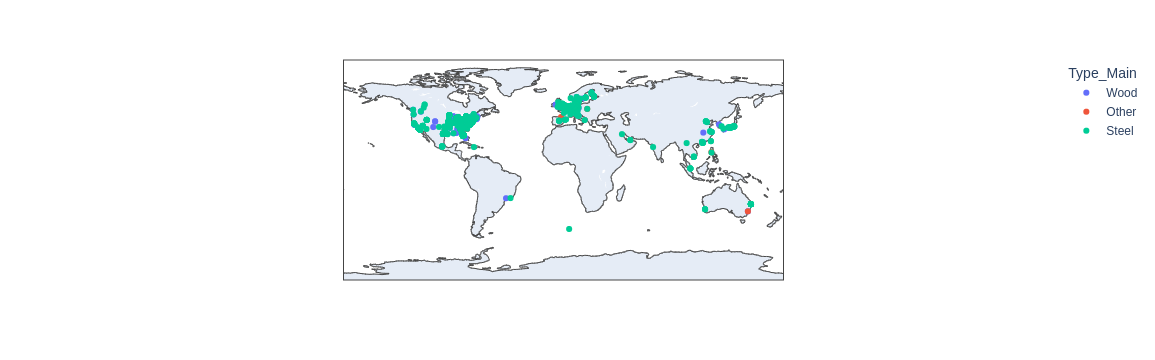

In [4]:
fig = px.scatter_geo(coaster, lat='latitude',
                     lon='longitude',
                     color='Type_Main'
                    )
fig.show()

# Scrub the Opening Date Column

In [5]:
coaster['opening_date_clean'] = coaster['Opening date'].str.replace('\xa0',' ') \
    .str.split(';').str[0]
coaster['opening_date_clean'] = coaster['opening_date_clean'] \
    .str.replace('1950s','1950') \
    .str.replace('[1]','', regex=False) \
    .str.replace('[2]','', regex=False) \
    .str.replace(' (original)July 15, 2005 (reopening)','', regex=False) \
    .str.replace('  as Runaway Train 19 March 2014 as Scorpion Express ','', regex=False) \
    .str.replace('February 8, 2001June 23, 2018','February 8, 2001', regex=False) \
    .str.replace('1984Opened10 March 2007Reopened','1984', regex=False) \
    .str.replace('1985 (original)1993 (current location)','1985', regex=False) \
    .str.replace(' as Blauer Enzian, 1986 as Thunder Run','', regex=False) \
    .str.replace('1984Opened10 March 2007Reopened','1984', regex=False) \
    .str.replace('7 June 1987 as Runaway Train 19 March 2014 as Scorpion Express','7 June 1987', regex=False) \
    .str.replace('July 20, 1985 (one side) 1986 (other side)', 'July 20, 1985', regex=False) \
    .str.replace('1975 (Chicago Loop), 1982 (Corkscrew), 1987 (Canobie Lake Corkscrew)', '1975', regex=False) \
    .str.replace('2 April 1987 (as Rat Ride)4 April 2010 (as Raptor Attack)','2 April 1987', regex=False) \
    .str.replace('1989 (as Eurosat) September 2018 (as Eurosat - CanCan Coaster)', '1989', regex=False) \
    .str.replace('1948 (Crystal Beach), June 25, 1994 (relocation to Great Escape)', '1948', regex=False) \
    .str.replace('26 December 19957 April 2012', '26 December 1995', regex=False) \
    .str.replace('30 June 199619 March 20052008', '30 June 1996', regex=False) \
    .str.replace('October 1, 1996 (Barnstormer)March 12, 2012 (Great Goofini)', 'October 1, 1996', regex=False) \
    .str.replace('23 March 1996(X:/ No Way Out) 31 March 2018(The Walking Dead: The Ride)', '23 March 1996', regex=False) \
    .str.replace('23 January 1997Tower of Terror)', '23 January 1997', regex=False) \
    .str.replace('April 2, 1999May 23, 2009Re-theming', 'April 2, 1999', regex=False) \
    .str.replace('1999 as Road Runner Railway', '1999', regex=False) \
    .str.replace("February 8, 2001(as Mullholland Madness)July 1, 2011(as Goofy's Sky School)","February 8, 2001", regex=False) \
    .str.replace('March 15, 2013 (8 years ago)', 'March 15, 2013', regex=False) \
    .str.replace('Easter 2022', '2022', regex=False)
coaster['opening_date_clean'] = pd.to_datetime(coaster['opening_date_clean'])

# Scrub the Speeds

In [6]:
coaster['Speed'] = coaster['Speed'].str.replace('\xa0',' ')
coaster['speed1'] = coaster['Speed'] \
    .str.replace('[1]','', regex=False) \
    .str.replace('[2]','', regex=False) \
    .str.split('(').str[0]
coaster['speed2'] = coaster['Speed'] \
    .str.replace('[1]','', regex=False) \
    .str.replace('[2]','', regex=False) \
    .str.split('(').str[1] \
    .str.replace(')','', regex=False)

coaster['speed1_value'] = coaster['speed1'].str.split(' ').str[0].astype('float')
coaster['speed1_unit'] = coaster['speed1'].str.split(' ').str[1]

KMH_MPH = 0.6213711922

coaster['speed_mph'] = np.nan
coaster.loc[coaster['speed1_unit'] == 'mph', 'speed_mph'] = \
    coaster.loc[coaster['speed1_unit'] == 'mph']['speed1_value']
coaster.loc[coaster['speed1_unit'] == 'km/h', 'speed_mph'] = \
    coaster.loc[coaster['speed1_unit'] == 'km/h']['speed1_value'] * KMH_MPH
coaster['speed_mph'] = coaster['speed_mph'].round(1)

Text(0.5, 0, 'mph')

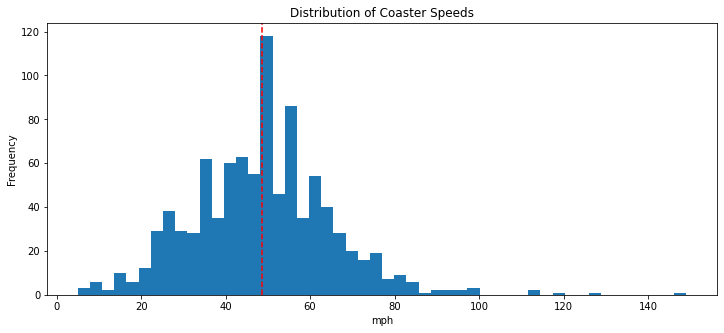

In [7]:
ax = coaster['speed_mph'].plot(kind='hist', bins=50,
                          title='Distribution of Coaster Speeds',
                              figsize=(12, 5))
ax.axvline(coaster['speed_mph'].mean(), color='red', ls='--')
ax.set_xlabel('mph')

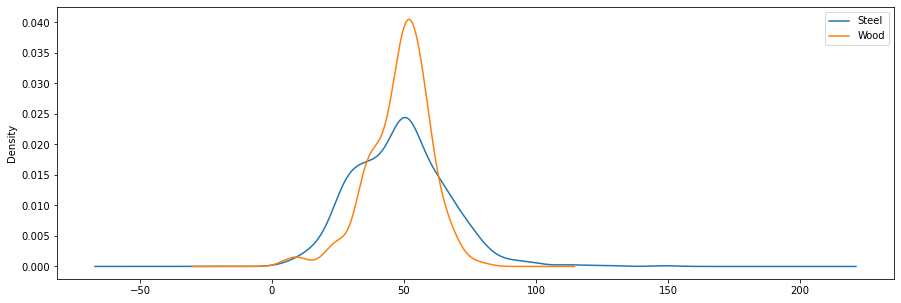

In [8]:
coaster.query('Type_Main != "Other"') \
    .groupby('Type_Main')['speed_mph'].plot(kind='kde', figsize=(15, 5))
plt.legend()

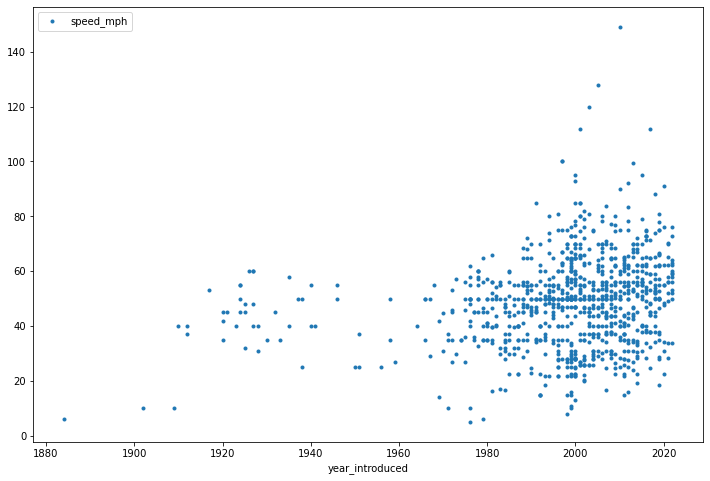

In [9]:
coaster.plot(x='year_introduced', y='speed_mph',
             figsize=(12, 8), style='.')

In [13]:
coaster = coaster.drop('General statistics', axis=1) \
    .drop('General Statistics', axis=1)

In [23]:
coaster['Height'] = coaster['Height'].str.replace('\xa0',' ')

In [39]:
coaster['height_value'] = coaster['Height'].str.split('(').str[0].str.split(' ').str[0].str.replace(',','').astype('float')
coaster['height_unit'] = coaster['Height'].str.split('(').str[0].str.split(' ').str[1]
coaster.loc[coaster['Height'] == '100 or 105 ft (30 or 32 m)', 'height_value'] = 100
coaster.loc[coaster['Height'] == '100 or 105 ft (30 or 32 m)', 'height_unit'] = 'ft'

In [60]:
M_TO_FT = 3.28084
coaster['height_ft'] = coaster.loc[coaster['height_unit'] == 'ft']['height_value']
coaster['height_ft'] = coaster.loc[coaster['height_unit'] == 'm']['height_value'] * M_TO_FT
coaster['height_ft'] = coaster['height_ft'].round(1)

Text(0.5, 0, 'ft')

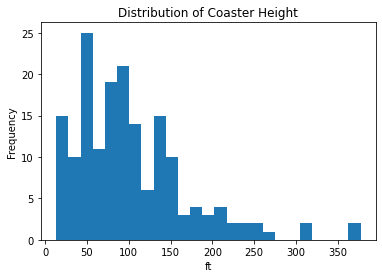

In [61]:
ax = coaster['height_ft'].plot(kind='hist', bins=25, title='Distribution of Coaster Height')
ax.set_xlabel('ft')

In [64]:
import seaborn as sns

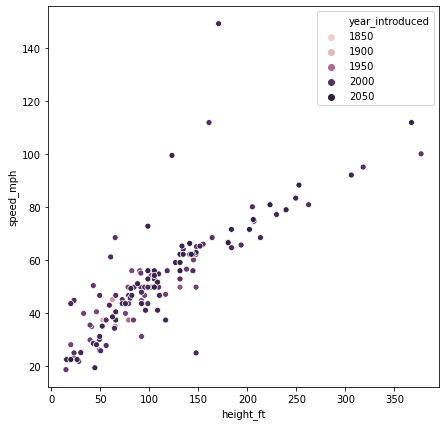

In [69]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x='height_ft', y='speed_mph', data=coaster, hue='year_introduced')

In [75]:
coaster.head()

,index,coaster_name,Length,Speed,Location,Coordinates,Status,Opening date,Type,Manufacturer,Height restriction,Model,Height,Inversions,Lift/launch system,Cost,Trains,Park section,Duration,Capacity,G-force,Designer,Max vertical angle,Drop,Soft opening date,Fast Lane available,Replaced,Track layout,Fastrack available,Soft opening date.1,Closing date,Opened,Replaced by,Website,Flash Pass Available,Must transfer from wheelchair,Theme,Single rider line available,Restraint Style,Flash Pass available,Acceleration,Restraints,Name,year_introduced,coords_v1,lat_v1,lon_v1,latitude,longitude,Type_Main,opening_date_clean,speed1,speed2,speed1_value,speed1_unit,speed_mph,height_value,height_unit,height_ft
0,Switchback Railway,Switchback Railway,600 ft (180 m),6 mph (9.7 km/h),Coney Island,".mw-parser-output .geo-default,.mw-parser-outp...",Removed,"June 16, 1884",Wood,LaMarcus Adna Thompson,NaN,Lift Packed,50 ft (15 m),NaN,gravity,NaN,NaN,Coney Island Cyclone Site,1:00,1600 riders per hour,2.9,LaMarcus Adna Thompson,30°,43 ft (13 m),NaN,NaN,NaN,Gravity pulled coaster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1884,40.574°N 73.978°W,40.574°N,73.978°W,40.5740,-73.9780,Wood,1884-06-16,6 mph,9.7 km/h,6.0,mph,6.0,50.0,ft,NaN
1,Flip Flap Railway,Flip Flap Railway,NaN,NaN,Sea Lion Park,".mw-parser-output .geo-default,.mw-parser-outp...",Removed,1895,Wood,Lina Beecher,NaN,NaN,NaN,1,NaN,NaN,a single car. Riders are arranged 1 across in ...,NaN,NaN,NaN,12,Lina Beecher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1895,40.578°N 73.979°W,40.578°N,73.979°W,40.5780,-73.9790,Wood,1895-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,Switchback Railway (Euclid Beach Park),NaN,NaN,"Cleveland, Ohio, United States",".mw-parser-output .geo-default,.mw-parser-outp...",Closed,NaN,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1896,41.580°N 81.570°W,41.580°N,81.570°W,41.5800,-81.5700,Other,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Loop the Loop,Loop the Loop (Coney Island),NaN,NaN,Other,".mw-parser-output .geo-default,.mw-parser-outp...",Removed,1901,Steel,Edwin Prescott,NaN,NaN,NaN,1,NaN,NaN,a single car. Riders are arranged 2 across in ...,NaN,NaN,NaN,NaN,Edward A. Green,NaN,NaN,NaN,NaN,Switchback Railway,NaN,NaN,NaN,1910,NaN,Giant Racer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1901,40.5745°N 73.978°W,40.5745°N,73.978°W,40.5745,-73.9780,Steel,1901-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Loop the Loop,Loop the Loop (Young's Pier),NaN,NaN,Other,".mw-parser-output .geo-default,.mw-parser-outp...",Removed,1901,Steel,Edwin Prescott,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Edward A. Green,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1901,39.3538°N 74.4342°W,39.3538°N,74.4342°W,39.3538,-74.4342,Steel,1901-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
coaster['Inversions'].str.replace("None", "")

0       NaN
1         1
2       NaN
3         1
4         1
       ... 
1082      3
1083      2
1084      0
1085      0
1086      3
Name: Inversions, Length: 1087, dtype: object

In [142]:
coaster['Inversions'] = coaster['Inversions'].str.replace('\xa0',' ') \
              .str.replace("None","") \
    .str.replace("1 (traversed 2 times, forward and backward)", "2", regex=False) \
    .str.replace("1 (traversed twice)", "2", regex=False) \
    .str.replace("2 (once forwards and once backwards","2", regex=False) \
    .str.replace(')','', regex=False) \
    .str.replace("2(1forward,1 backward","2", regex=False) \
    .str.replace("6 [3 on track, but each run traverses the track twice]", "6", regex=False) \
    .str.replace("6 (3 forward and 3 backward", "6", regex=False) \
    .str.replace("6 (3 forward, 3 backward", "6", regex=False) \
    .str.replace("none","") \
    .str.replace("3 (each traversed twice","6", regex=False) \
    .str.replace("1 (2007 2 (1997-2006", "1", regex=False) \
    .str.replace("1 (2000–20060 (2007–2009", "1", regex=False) \
    .str.replace("1 (transversed twice","1", regex=False) \
    .str.replace("3 inversions. Each completed both forwards and backwards.", "3", regex=False) \
    .str.replace("[1]", "", regex=False) \
    .str.replace("2 (1 non-vertical", "2", regex=False) \
    .str.replace("1 (loop", "1", regex=False) \
    .str.replace("3 track inversions (14 including seat inversions", "3", regex=False) \
    .str.replace("2 (Corkscrew, Inline Twist", "2", regex=False) \
    .str.replace("3 (Corkscrew, Zero-G Roll, Inline Twist", "3", regex=False) \
    .str.replace("0[4]","0", regex=False) \
    .str.replace("6 (2 track inversions", "6", regex=False) \
    .str.replace("[2]","", regex=False)

In [155]:
coaster['Inversions_clean'] = pd.to_numeric(coaster['Inversions']).fillna(0).astype('int')

In [158]:
coaster['Inversions_clean'].value_counts()

0     665
3     100
2      89
5      63
1      62
4      52
6      31
7      18
8       3
10      2
14      1
9       1
Name: Inversions_clean, dtype: int64

In [182]:
coaster['Gforce_clean'] = coaster['G-force'].str.replace('g','', regex=False) \
    .str.replace('Gs','', regex=False) \
    .str.replace("4.9 (Back Seat)4.0 (Front Seat)","4.9", regex=False) \
    .str.replace("[1]","", regex=False) \
    .str.replace("[2]","", regex=False) \
    .str.replace("[4]","", regex=False) \
    .str.replace(" G (Positive)","", regex=False) \
    .str.replace("-1,5 and 4,5", "4.5", regex=False) \
    .str.replace("4.2 & -1", "4.2", regex=False) \
    .str.replace("G","", regex=False) \
    .str.replace("0.2-2","2", regex=False) \
    .str.replace("Between 3 and 4 ", "3.5", regex=False)

coaster['Gforce_clean'] = pd.to_numeric(coaster['Gforce_clean'])

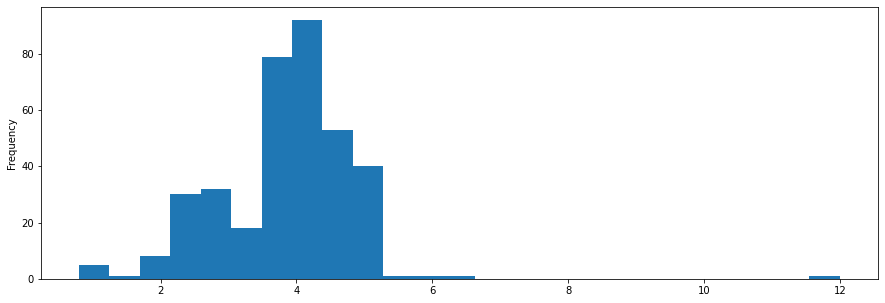

In [190]:
coaster['Gforce_clean'].plot(kind='hist', bins=25, figsize=(15, 5))

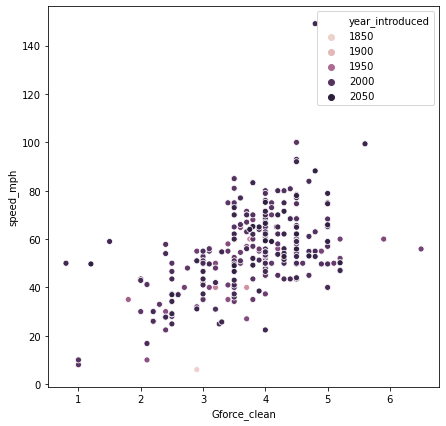

In [187]:
fig, ax = plt.subplots(figsize=(7, 7))

sns.scatterplot(x='Gforce_clean', y='speed_mph', data=coaster, hue='year_introduced')

In [199]:
coaster.drop(['index','coords_v1','lat_v1','lon_v1','Coordinates'], axis=1) \
    .to_csv('coaster_db.csv', index=False)